## One-Dimensional Compaction in a Three-Dimensional Flow Field

This problem is based on the problem presented in the SUB-WT report
(Leake and Galloway, 2007) and represent groundwater development in a
hypothetical aquifer that includes some features typical of basin-fill
aquifers in an arid or semi-arid environment.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-csub-p04"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 3  # Number of periods
nlay = 4  # Number of layers
nrow = 20  # Number of rows
ncol = 15  # Number of columns
delr = 2000.0  # Column width ($m$)
delc = 2000.0  # Row width ($m$)
top = 150.0  # Top of the model ($ft$)
botm_str = "50., -100., -150., -350."  # Layer bottom elevations ($m$)
strt = 100.0  # Starting head ($m$)
icelltype_str = "1, 0, 0, 0"  # Cell conversion type
k11_str = "4., 4., 0.01, 4."  # Horizontal hydraulic conductivity ($m/d$)
k33_str = "0.4, 0.4, 0.01, 0.4"  # Vertical hydraulic conductivity ($m/d$)
sy_str = "0.3, 0.3, 0.4, 0.3"  # Specific yield (unitless)
gammaw = 9806.65  # Compressibility of water (Newtons/($m^3$)
beta = 4.6612e-10  # Specific gravity of water (1/$Pa$)
sgm_str = "1.77, 1.77, 1.60, 1.77"  # Specific gravity of moist soils (unitless)
sgs_str = "2.06, 2.05, 1.94, 2.06"  # Specific gravity of saturated soils (unitless)
cg_theta_str = "0.32, 0.32, 0.45, 0.32"  # Coarse-grained material porosity (unitless)
cg_ske_str = "0.005, 0.005, 0.01, 0.005"  # Elastic specific storage ($1/m$)
ib_thick_str = "45., 70., 50., 90."  # Interbed thickness ($m$)
ib_theta = 0.45  # Interbed initial porosity (unitless)
ib_cr = 0.01  # Interbed recompression index (unitless)
ib_cv = 0.25  # Interbed compression index (unitless)
stress_offset = 15.0  # Initial preconsolidation stress offset ($m$)

# Static temporal data used by TDIS file
tdis_ds = (
    (0.0, 1, 1.0),
    (21915.0, 60, 1.0),
    (21915.0, 60, 1.0),
)

# Parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]
sy = [float(value) for value in sy_str.split(",")]
sgm = [float(value) for value in sgm_str.split(",")]
sgs = [float(value) for value in sgs_str.split(",")]
cg_theta = [float(value) for value in cg_theta_str.split(",")]
cg_ske = [float(value) for value in cg_ske_str.split(",")]
ib_thick = [float(value) for value in ib_thick_str.split(",")]

# Load active domain and create idomain array
fname = "idomain.txt"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:2f05a27b6f71e564c0d3616e3fd00ac8",
)
ib = np.loadtxt(fpath, dtype=int)
idomain = np.tile(ib, (nlay, 1))

# Constant head boundary cells
chd_locs = [(nrow - 1, 7), (nrow - 1, 8)]
c6 = []
for i, j in chd_locs:
    for k in range(nlay):
        c6.append([k, i, j, strt])

# Recharge boundary cells
rch_rate = 5.5e-4
rch6 = []
for i in range(nrow):
    for j in range(ncol):
        if ib[i, j] != 2 or (i, j) in chd_locs:
            continue
        rch6.append([0, i, j, rch_rate])

# Well boundary cells
well_locs = (
    (1, 8, 9),
    (3, 11, 6),
)
well_rates = (
    -72000,
    0.0,
)
wel6 = {}
for idx, q in enumerate(well_rates):
    spd = []
    for k, i, j in well_locs:
        spd.append([k, i, j, q])
    wel6[idx + 1] = spd

# Create interbed package data
icsubno = 0
csub_pakdata = []
boundname_dict = {}
for i in range(nrow):
    for j in range(ncol):
        if ib[i, j] < 1 or (i, j) in chd_locs:
            continue
        for k in range(nlay):
            boundname = f"{k + 1:02d}_{i + 1:02d}_{j + 1:02d}"
            boundname_dict[boundname] = (icsubno,)
            ib_lst = [
                icsubno,
                (k, i, j),
                "nodelay",
                stress_offset,
                ib_thick[k],
                1.0,
                ib_cv,
                ib_cr,
                ib_theta,
                999.0,
                999.0,
                boundname,
            ]
            csub_pakdata.append(ib_lst)
            icsubno += 1

# Solver parameters
nouter = 100
ninner = 300
hclose = 1e-9
rclose = 1e-6
linaccel = "bicgstab"
relax = 0.97

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        linear_acceleration=linaccel,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        relaxation_factor=relax,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, save_flows=True, newtonoptions="newton"
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
    )
    # gwf obs
    flopy.mf6.ModflowUtlobs(
        gwf,
        digits=10,
        print_input=True,
        continuous={
            "gwf_obs.csv": [
                ("h1l1", "HEAD", (0, 8, 9)),
                ("h1l2", "HEAD", (1, 8, 9)),
                ("h1l3", "HEAD", (2, 8, 9)),
                ("h1l4", "HEAD", (3, 8, 9)),
                ("h2l1", "HEAD", (0, 11, 6)),
                ("h2l2", "HEAD", (1, 11, 6)),
                ("h3l2", "HEAD", (2, 11, 6)),
                ("h4l2", "HEAD", (3, 11, 6)),
            ]
        },
    )

    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=icelltype,
        ss=0.0,
        sy=sy,
        steady_state={0: True},
        transient={1: True},
    )
    csub = flopy.mf6.ModflowGwfcsub(
        gwf,
        print_input=True,
        save_flows=True,
        compression_indices=True,
        update_material_properties=True,
        boundnames=True,
        ninterbeds=len(csub_pakdata),
        sgm=sgm,
        sgs=sgs,
        cg_theta=cg_theta,
        cg_ske_cr=cg_ske,
        beta=beta,
        gammaw=gammaw,
        packagedata=csub_pakdata,
    )
    opth = f"{sim_name}.csub.obs"
    csub_csv = opth + ".csv"
    obs = [
        ("w1l1", "interbed-compaction", boundname_dict["01_09_10"]),
        ("w1l2", "interbed-compaction", boundname_dict["02_09_10"]),
        ("w1l3", "interbed-compaction", boundname_dict["03_09_10"]),
        ("w1l4", "interbed-compaction", boundname_dict["04_09_10"]),
        ("w2l1", "interbed-compaction", boundname_dict["01_12_07"]),
        ("w2l2", "interbed-compaction", boundname_dict["02_12_07"]),
        ("w2l3", "interbed-compaction", boundname_dict["03_12_07"]),
        ("w2l4", "interbed-compaction", boundname_dict["04_12_07"]),
        ("s1l1", "coarse-compaction", (0, 8, 9)),
        ("s1l2", "coarse-compaction", (1, 8, 9)),
        ("s1l3", "coarse-compaction", (2, 8, 9)),
        ("s1l4", "coarse-compaction", (3, 8, 9)),
        ("s2l1", "coarse-compaction", (0, 11, 6)),
        ("s2l2", "coarse-compaction", (1, 11, 6)),
        ("s2l3", "coarse-compaction", (2, 11, 6)),
        ("s2l4", "coarse-compaction", (3, 11, 6)),
        ("c1l1", "compaction-cell", (0, 8, 9)),
        ("c1l2", "compaction-cell", (1, 8, 9)),
        ("c1l3", "compaction-cell", (2, 8, 9)),
        ("c1l4", "compaction-cell", (3, 8, 9)),
        ("c2l1", "compaction-cell", (0, 11, 6)),
        ("c2l2", "compaction-cell", (1, 11, 6)),
        ("c2l3", "compaction-cell", (2, 11, 6)),
        ("c2l4", "compaction-cell", (3, 11, 6)),
        ("w2l4q", "csub-cell", (3, 11, 6)),
        ("gs1", "gstress-cell", (0, 8, 9)),
        ("es1", "estress-cell", (0, 8, 9)),
        ("pc1", "preconstress-cell", (0, 8, 9)),
        ("gs2", "gstress-cell", (1, 8, 9)),
        ("es2", "estress-cell", (1, 8, 9)),
        ("pc2", "preconstress-cell", (1, 8, 9)),
        ("gs3", "gstress-cell", (2, 8, 9)),
        ("es3", "estress-cell", (2, 8, 9)),
        ("pc3", "preconstress-cell", (2, 8, 9)),
        ("gs4", "gstress-cell", (3, 8, 9)),
        ("es4", "estress-cell", (3, 8, 9)),
        ("pc4", "preconstress-cell", (3, 8, 9)),
        ("sk1l2", "ske-cell", (1, 8, 9)),
        ("sk2l4", "ske-cell", (3, 11, 6)),
        ("t1l2", "theta", (1, 8, 9)),
        ("w1qie", "elastic-csub", boundname_dict["02_09_10"]),
        ("w1qii", "inelastic-csub", boundname_dict["02_09_10"]),
        ("w1qaq", "coarse-csub", (1, 8, 9)),
        ("w1qt", "csub-cell", (1, 8, 9)),
        ("w1wc", "wcomp-csub-cell", (1, 8, 9)),
        ("w2qie", "elastic-csub", boundname_dict["04_12_07"]),
        ("w2qii", "inelastic-csub", boundname_dict["04_12_07"]),
        ("w2qaq", "coarse-csub", (3, 11, 6)),
        ("w2qt ", "csub-cell", (3, 11, 6)),
        ("w2wc", "wcomp-csub-cell", (3, 11, 6)),
    ]
    orecarray = {csub_csv: obs}
    csub.obs.initialize(
        filename=opth, digits=10, print_input=True, continuous=orecarray
    )

    flopy.mf6.ModflowGwfchd(gwf, stress_period_data={0: c6})
    flopy.mf6.ModflowGwfrch(gwf, stress_period_data={0: rch6})
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel6)

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        printrecord=[("BUDGET", "ALL")],
        saverecord=[("BUDGET", "ALL"), ("HEAD", "ALL")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results, starting with a few utilities.

In [4]:
# Set figure properties specific to the problem
figure_size = (6.8, 5.5)
arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)
plot_tags = (
    "W1L",
    "W2L",
    "S1L",
    "S2L",
    "C1L",
    "C2L",
)
compaction_heading = ("row 9, column 10", "row 12, column 7")


def get_csub_observations(sim):
    name = sim.name
    gwf = sim.get_model(sim_name)
    csub_obs = gwf.csub.output.obs().data
    csub_obs["totim"] /= 365.25

    # set initial preconsolidation stress to stress period 1 value
    slist = [name for name in csub_obs.dtype.names if "PC" in name]
    for tag in slist:
        csub_obs[tag][0] = csub_obs[tag][1]

    # set initial storativity to stress period 1 value
    sk_tags = (
        "SK1L2",
        "SK2L4",
    )
    for tag in sk_tags:
        if tag in csub_obs.dtype.names:
            csub_obs[tag][0] = csub_obs[tag][1]

    return csub_obs


def calc_compaction_at_surface(sim):
    """Calculate the compaction at the surface"""
    csub_obs = get_csub_observations(sim)
    for tag in plot_tags:
        for k in (3, 2, 1):
            tag0 = f"{tag}{k}"
            tag1 = f"{tag}{k + 1}"
            csub_obs[tag0] += csub_obs[tag1]
    return csub_obs


def plot_compaction_values(ax, sim, tagbase="W1L"):
    colors = ["#FFF8DC", "#D2B48C", "#CD853F", "#8B4513"][::-1]
    obs = calc_compaction_at_surface(sim)
    for k in range(nlay):
        fc = colors[k]
        tag = f"{tagbase}{k + 1}"
        label = f"Layer {k + 1}"
        ax.fill_between(obs["totim"], obs[tag], y2=0, color=fc, label=label)


def plot_grid(sim, silent=True):
    with styles.USGSMap():
        name = sim.name
        gwf = sim.get_model(name)
        extents = gwf.modelgrid.extent

        # read simulated heads
        hobj = gwf.output.head()
        h0 = hobj.get_data(kstpkper=(0, 0))
        h1 = hobj.get_data(kstpkper=(59, 1))
        hsxs0 = h0[0, 8, :]
        hsxs1 = h1[0, 8, :]

        # get delr array
        dx = gwf.dis.delr.array

        # create x-axis for cross-section
        hxloc = np.arange(1000, 2000.0 * 15, 2000.0)

        # set cross-section location
        y = 2000.0 * 11.5
        xsloc = [(extents[0], extents[1]), (y, y)]

        # well locations
        w1loc = (9.5 * 2000.0, 11.75 * 2000.0)
        w2loc = (6.5 * 2000.0, 8.5 * 2000.0)

        fig = plt.figure(figsize=(6.8, 5), constrained_layout=True)
        gs = mpl.gridspec.GridSpec(7, 10, figure=fig, wspace=100)
        plt.axis("off")

        ax = fig.add_subplot(gs[:, 0:6])
        # ax.set_aspect('equal')
        mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=extents)
        mm.plot_grid(lw=0.5, color="0.5")
        mm.plot_bc(ftype="WEL", kper=1, plotAll=True)
        mm.plot_bc(ftype="CHD", color="blue")
        mm.plot_bc(ftype="RCH", color="green")
        mm.plot_inactive(color_noflow="0.75")
        mm.ax.plot(xsloc[0], xsloc[1], color="orange", lw=1.5)
        # contour steady state heads
        cl = mm.contour_array(
            h0,
            masked_values=[1.0e30],
            levels=np.arange(115, 200, 5),
            colors="black",
            linestyles="dotted",
            linewidths=0.75,
        )
        ax.clabel(cl, fmt="%3i", inline_spacing=0.1)
        # well text
        styles.add_annotation(
            ax=ax,
            text="Well 1, layer 2",
            bold=False,
            italic=False,
            xy=w1loc,
            xytext=(w1loc[0] - 3200, w1loc[1] + 1500),
            ha="right",
            va="center",
            zorder=100,
            arrowprops=arrow_props,
        )
        styles.add_annotation(
            ax=ax,
            text="Well 2, layer 4",
            bold=False,
            italic=False,
            xy=w2loc,
            xytext=(w2loc[0] + 3000, w2loc[1]),
            ha="left",
            va="center",
            zorder=100,
            arrowprops=arrow_props,
        )
        ax.set_ylabel("y-coordinate, in meters")
        ax.set_xlabel("x-coordinate, in meters")
        styles.heading(ax, letter="A", heading="Map view")
        styles.remove_edge_ticks(ax)

        ax = fig.add_subplot(gs[0:5, 6:])
        mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"row": 8})
        mm.plot_grid(lw=0.5, color="0.5")
        # items for legend
        mm.ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="green",
            mec="black",
            mew=0.5,
            label="Recharge",
        )
        mm.ax.plot(
            -1000, -1000, "s", ms=5, color="red", mec="black", mew=0.5, label="Well"
        )
        mm.ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="blue",
            mec="black",
            mew=0.5,
            label="Constant head",
        )
        mm.ax.plot(
            -1000,
            -1000,
            "s",
            ms=5,
            color="0.75",
            mec="black",
            mew=0.5,
            label="Inactive",
        )
        mm.ax.plot(
            [-1000, -1001],
            [-1000, -1000],
            color="orange",
            lw=1.5,
            label="Cross-section line",
        )
        # aquifer coloring
        ax.fill_between([0, dx.sum()], y1=150, y2=-100, color="cyan", alpha=0.5)
        ax.fill_between([0, dx.sum()], y1=-100, y2=-150, color="#D2B48C", alpha=0.5)
        ax.fill_between([0, dx.sum()], y1=-150, y2=-350, color="#00BFFF", alpha=0.5)
        # well coloring
        ax.fill_between(
            [dx.cumsum()[8], dx.cumsum()[9]], y1=50, y2=-100, color="red", lw=0
        )
        # labels
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=300,
            y=-97,
            text="Upper aquifer",
            va="bottom",
            ha="left",
            fontsize=9,
        )
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=300,
            y=-147,
            text="Confining unit",
            va="bottom",
            ha="left",
            fontsize=9,
        )
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=300,
            y=-347,
            text="Lower aquifer",
            va="bottom",
            ha="left",
            fontsize=9,
        )
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=29850,
            y=53,
            text="Layer 1",
            va="bottom",
            ha="right",
            fontsize=9,
        )
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=29850,
            y=-97,
            text="Layer 2",
            va="bottom",
            ha="right",
            fontsize=9,
        )
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=29850,
            y=-147,
            text="Layer 3",
            va="bottom",
            ha="right",
            fontsize=9,
        )
        styles.add_text(
            ax=ax,
            transform=False,
            bold=False,
            italic=False,
            x=29850,
            y=-347,
            text="Layer 4",
            va="bottom",
            ha="right",
            fontsize=9,
        )
        ax.plot(
            hxloc,
            hsxs0,
            lw=0.75,
            color="black",
            ls="dotted",
            label="Steady-state\nwater level",
        )
        ax.plot(
            hxloc,
            hsxs1,
            lw=0.75,
            color="black",
            ls="dashed",
            label="Water-level\nafter period 2",
        )
        ax.set_ylabel("Elevation, in meters")
        ax.set_xlabel("x-coordinate along model row 9, in meters")
        styles.graph_legend(
            mm.ax,
            ncol=2,
            bbox_to_anchor=(0.7, -0.6),
            borderaxespad=0,
            frameon=False,
            loc="lower center",
        )
        styles.heading(ax, letter="B", heading="Cross-section view")
        styles.remove_edge_ticks(ax)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_stresses(sim, silent=True):
    with styles.USGSPlot() as fs:
        name = sim.name

        cd = get_csub_observations(sim)
        tmax = cd["totim"][-1]

        fig, axes = plt.subplots(
            ncols=1, nrows=4, figsize=figure_size, sharex=True, constrained_layout=True
        )

        idx = 0
        ax = axes[idx]
        ax.set_xlim(0, tmax)
        ax.set_ylim(110, 150)
        ax.plot(
            cd["totim"], cd["PC1"], color="blue", lw=1, label="Preconsolidation stress"
        )
        ax.plot(cd["totim"], cd["ES1"], color="red", lw=1, label="Effective stress")
        styles.heading(ax, letter="A", heading="Model layer 1, row 9, column 10")
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = axes[idx]
        ax.set_ylim(185, 205)
        ax.plot(cd["totim"], cd["GS1"], color="black", lw=1)
        styles.heading(ax, letter="B", heading="Model layer 1, row 9, column 10")
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = axes[idx]
        ax.set_ylim(270, 310)
        ax.plot(cd["totim"], cd["PC2"], color="blue", lw=1)
        ax.plot(cd["totim"], cd["ES2"], color="red", lw=1)
        styles.heading(ax, letter="C", heading="Model layer 2, row 9, column 10")
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = axes[idx]
        ax.set_ylim(495, 515)
        ax.plot(
            [-100, -50],
            [-100, -100],
            color="blue",
            lw=1,
            label="Preconsolidation stress",
        )
        ax.plot([-100, -50], [-100, -100], color="red", lw=1, label="Effective stress")
        ax.plot(cd["totim"], cd["GS2"], color="black", lw=1, label="Geostatic stress")
        styles.graph_legend(ax, ncol=3, bbox_to_anchor=(0.9, -0.6))
        styles.heading(ax, letter="D", heading="Model layer 2, row 9, column 10")
        styles.remove_edge_ticks(ax)
        ax.set_xlabel("Simulation time, in years")
        ax.set_ylabel(" ")

        ax = fig.add_subplot(111, frame_on=False, xticks=[], yticks=[])
        ax.set_ylabel("Stress, in meters of water")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-01.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_compaction(sim, silent=True):
    with styles.USGSPlot():
        name = sim.name

        fig, axes = plt.subplots(
            ncols=2, nrows=3, figsize=figure_size, sharex=True, constrained_layout=True
        )
        axes = axes.flatten()

        idx = 0
        ax = axes[idx]
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 1)
        plot_compaction_values(ax, sim, tagbase=plot_tags[idx])
        ht = f"Interbed compaction\n{compaction_heading[0]}"
        styles.heading(ax, letter="A", heading=ht)
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = axes[idx]
        ax.set_ylim(0, 1)
        plot_compaction_values(ax, sim, tagbase=plot_tags[idx])
        ht = f"Interbed compaction\n{compaction_heading[1]}"
        styles.heading(ax, letter="B", heading=ht)
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = axes[idx]
        ax.set_ylim(0, 1)
        plot_compaction_values(ax, sim, tagbase=plot_tags[idx])
        ht = f"Coarse-grained compaction\n{compaction_heading[0]}"
        styles.heading(ax, letter="C", heading=ht)
        styles.remove_edge_ticks(ax)

        idx += 1
        ax = axes[idx]
        ax.set_ylim(0, 1)
        plot_compaction_values(ax, sim, tagbase=plot_tags[idx])
        ht = f"Coarse-grained compaction\n{compaction_heading[1]}"
        styles.heading(ax, letter="D", heading=ht)
        styles.remove_edge_ticks(ax)
        styles.graph_legend(ax, ncol=2, loc="lower right")

        idx += 1
        ax = axes[idx]
        ax.set_ylim(0, 1)
        plot_compaction_values(ax, sim, tagbase=plot_tags[idx])
        ht = f"Total compaction\n{compaction_heading[0]}"
        styles.heading(ax, letter="E", heading=ht)
        styles.remove_edge_ticks(ax)
        ax.set_ylabel(" ")
        ax.set_xlabel(" ")

        idx += 1
        ax = axes.flat[idx]
        ax.set_ylim(0, 1)
        plot_compaction_values(ax, sim, tagbase=plot_tags[idx])
        ht = f"Total compaction\n{compaction_heading[1]}"
        styles.heading(ax, letter="F", heading=ht)
        styles.remove_edge_ticks(ax)

        ax = fig.add_subplot(111, frame_on=False, xticks=[], yticks=[])
        ax.set_ylabel(
            "Downward vertical displacement at the top of the model layer, in meters"
        )
        ax.set_xlabel("Simulation time, in years")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{name}-02.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_grid(sim, silent=silent)
    plot_stresses(sim, silent=silent)
    plot_compaction(sim, silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model ex-gwf-csub-p04...
    writing model name file...
    writing package dis...
    writing package obs_0...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package csub...
    writing package obs_1...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 8 based on size of stress_period_data
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 18 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MO

    Solving:  Stress period:     1    Time step:     1
    Solving:  Stress period:     2    Time step:     1
    Solving:  Stress period:     2    Time step:     2
    Solving:  Stress period:     2    Time step:     3
    Solving:  Stress period:     2    Time step:     4
    Solving:  Stress period:     2    Time step:     5
    Solving:  Stress period:     2    Time step:     6
    Solving:  Stress period:     2    Time step:     7
    Solving:  Stress period:     2    Time step:     8
    Solving:  Stress period:     2    Time step:     9
    Solving:  Stress period:     2    Time step:    10
    Solving:  Stress period:     2    Time step:    11


    Solving:  Stress period:     2    Time step:    12
    Solving:  Stress period:     2    Time step:    13
    Solving:  Stress period:     2    Time step:    14
    Solving:  Stress period:     2    Time step:    15
    Solving:  Stress period:     2    Time step:    16
    Solving:  Stress period:     2    Time step:    17
    Solving:  Stress period:     2    Time step:    18
    Solving:  Stress period:     2    Time step:    19
    Solving:  Stress period:     2    Time step:    20
    Solving:  Stress period:     2    Time step:    21
    Solving:  Stress period:     2    Time step:    22
    Solving:  Stress period:     2    Time step:    23
    Solving:  Stress period:     2    Time step:    24


    Solving:  Stress period:     2    Time step:    25
    Solving:  Stress period:     2    Time step:    26
    Solving:  Stress period:     2    Time step:    27
    Solving:  Stress period:     2    Time step:    28
    Solving:  Stress period:     2    Time step:    29
    Solving:  Stress period:     2    Time step:    30
    Solving:  Stress period:     2    Time step:    31
    Solving:  Stress period:     2    Time step:    32
    Solving:  Stress period:     2    Time step:    33
    Solving:  Stress period:     2    Time step:    34
    Solving:  Stress period:     2    Time step:    35


    Solving:  Stress period:     2    Time step:    36
    Solving:  Stress period:     2    Time step:    37
    Solving:  Stress period:     2    Time step:    38
    Solving:  Stress period:     2    Time step:    39
    Solving:  Stress period:     2    Time step:    40
    Solving:  Stress period:     2    Time step:    41
    Solving:  Stress period:     2    Time step:    42
    Solving:  Stress period:     2    Time step:    43
    Solving:  Stress period:     2    Time step:    44
    Solving:  Stress period:     2    Time step:    45
    Solving:  Stress period:     2    Time step:    46
    Solving:  Stress period:     2    Time step:    47


    Solving:  Stress period:     2    Time step:    48
    Solving:  Stress period:     2    Time step:    49
    Solving:  Stress period:     2    Time step:    50
    Solving:  Stress period:     2    Time step:    51
    Solving:  Stress period:     2    Time step:    52
    Solving:  Stress period:     2    Time step:    53
    Solving:  Stress period:     2    Time step:    54
    Solving:  Stress period:     2    Time step:    55
    Solving:  Stress period:     2    Time step:    56
    Solving:  Stress period:     2    Time step:    57
    Solving:  Stress period:     2    Time step:    58


    Solving:  Stress period:     2    Time step:    59
    Solving:  Stress period:     2    Time step:    60
    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     3    Time step:     2
    Solving:  Stress period:     3    Time step:     3
    Solving:  Stress period:     3    Time step:     4
    Solving:  Stress period:     3    Time step:     5
    Solving:  Stress period:     3    Time step:     6
    Solving:  Stress period:     3    Time step:     7
    Solving:  Stress period:     3    Time step:     8
    Solving:  Stress period:     3    Time step:     9
    Solving:  Stress period:     3    Time step:    10
    Solving:  Stress period:     3    Time step:    11
    Solving:  Stress period:     3    Time step:    12


    Solving:  Stress period:     3    Time step:    13
    Solving:  Stress period:     3    Time step:    14
    Solving:  Stress period:     3    Time step:    15
    Solving:  Stress period:     3    Time step:    16
    Solving:  Stress period:     3    Time step:    17
    Solving:  Stress period:     3    Time step:    18
    Solving:  Stress period:     3    Time step:    19
    Solving:  Stress period:     3    Time step:    20
    Solving:  Stress period:     3    Time step:    21
    Solving:  Stress period:     3    Time step:    22
    Solving:  Stress period:     3    Time step:    23
    Solving:  Stress period:     3    Time step:    24
    Solving:  Stress period:     3    Time step:    25
    Solving:  Stress period:     3    Time step:    26
    Solving:  Stress period:     3    Time step:    27


    Solving:  Stress period:     3    Time step:    28
    Solving:  Stress period:     3    Time step:    29
    Solving:  Stress period:     3    Time step:    30
    Solving:  Stress period:     3    Time step:    31
    Solving:  Stress period:     3    Time step:    32
    Solving:  Stress period:     3    Time step:    33
    Solving:  Stress period:     3    Time step:    34
    Solving:  Stress period:     3    Time step:    35
    Solving:  Stress period:     3    Time step:    36
    Solving:  Stress period:     3    Time step:    37
    Solving:  Stress period:     3    Time step:    38
    Solving:  Stress period:     3    Time step:    39
    Solving:  Stress period:     3    Time step:    40
    Solving:  Stress period:     3    Time step:    41
    Solving:  Stress period:     3    Time step:    42


    Solving:  Stress period:     3    Time step:    43
    Solving:  Stress period:     3    Time step:    44
    Solving:  Stress period:     3    Time step:    45
    Solving:  Stress period:     3    Time step:    46
    Solving:  Stress period:     3    Time step:    47
    Solving:  Stress period:     3    Time step:    48
    Solving:  Stress period:     3    Time step:    49
    Solving:  Stress period:     3    Time step:    50
    Solving:  Stress period:     3    Time step:    51
    Solving:  Stress period:     3    Time step:    52
    Solving:  Stress period:     3    Time step:    53
    Solving:  Stress period:     3    Time step:    54
    Solving:  Stress period:     3    Time step:    55
    Solving:  Stress period:     3    Time step:    56
    Solving:  Stress period:     3    Time step:    57


    Solving:  Stress period:     3    Time step:    58
    Solving:  Stress period:     3    Time step:    59
    Solving:  Stress period:     3    Time step:    60

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/02/08 12:35:29
 Elapsed run time:  1.992 Seconds

 Normal termination of simulation.
run_models took 2002.28 ms


/opt/hostedtoolcache/Python/3.9.21/x64/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


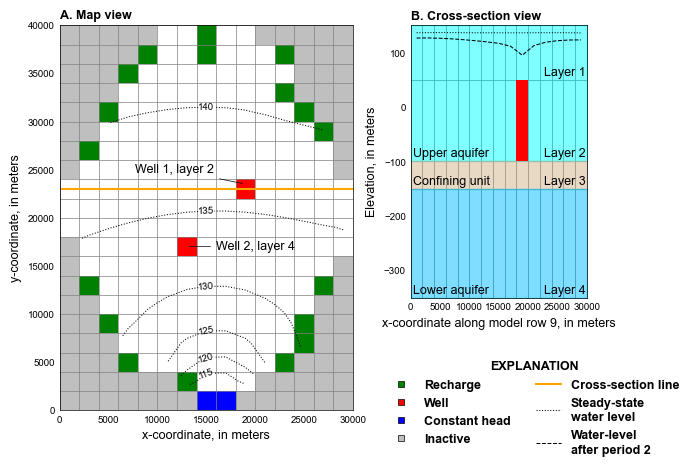

saving...'/home/runner/work/modflow6-examples/modflow6-examples/modflow6-examples/figures/ex-gwf-csub-p04-grid.png'


/tmp/ipykernel_11487/976685287.py:311: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(fpth)


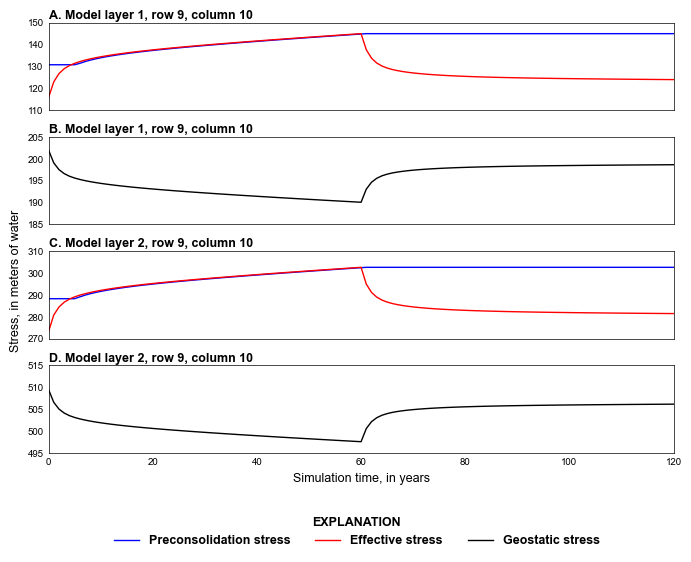

saving...'/home/runner/work/modflow6-examples/modflow6-examples/modflow6-examples/figures/ex-gwf-csub-p04-01.png'


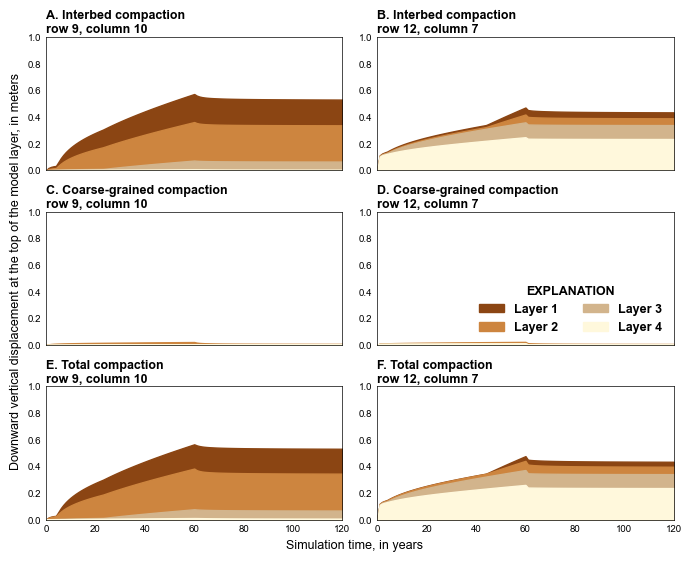

saving...'/home/runner/work/modflow6-examples/modflow6-examples/modflow6-examples/figures/ex-gwf-csub-p04-02.png'


In [5]:
def scenario(silent=False):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()